In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import cvxpy

# TODOs

Add final box to set of boxes for convex implementation.

Add periodic states (so box for e.g theta when calcualting area/volume if it is bigger than [0,2pi] then the "length" of that side is 2pi.

Double check convex method makes sense - specifically finding bound_plane.

# Fast Implementation of McCormick

In [4]:
class Line:
    # line = ax + by + c
    # coeffs = {"x":a, "y":b, "_const":c}
    def __init__(self,coeffs):
        self.coeffs = coeffs.copy()
    
    def mult_const(self,z):
        return Line({key:value*z for (key,value) in self.coeffs.items()})
    
    def add(self,l):
        return Line({key:(value + l.coeffs[key]) for (key,value) in self.coeffs.items()})
    
    def add_const(self,z):
        coeffs = self.coeffs.copy()
        coeffs["_const"] = coeffs["_const"] + z
        return Line(coeffs)
    
    def copy(self):
        return Line(self.coeffs.copy())
    
    def eval_line(self, var_bounds):
        min_val, max_val = self.coeffs["_const"], self.coeffs["_const"]
        
        for (key, value) in var_bounds.items():
            min_val += (value.lower if self.coeffs[key] > 0 else value.upper)*self.coeffs[key]
            max_val += (value.lower if self.coeffs[key] < 0 else value.upper)*self.coeffs[key]
        
        return BoxConstraints(min_val, max_val)
    
class LinearConstraints:

    def __init__(self, lower, upper, var_bounds):
        # lower/upper = Line2D object
        self.lower = lower
        self.upper = upper
        
        # var_bounds = {"x":BoxContstraints(-1,1), "y":BoxContstraints(-1,1)}
        self.var_bounds = var_bounds.copy()
        
    def add(self,l):
        lower_line = self.lower.add(l.lower)
        upper_line = self.upper.add(l.upper)
        return LinearConstraints(lower_line, upper_line, self.var_bounds)
    
    def add_const(self,z):
        lower_line = self.lower.add_const(z)
        upper_line = self.upper.add_const(z)
        return LinearConstraints(lower_line, upper_line, self.var_bounds)
    
    def mult_const(self,z):
        if z < 0:
            upper_line = self.lower.mult_const(z)
            lower_line = self.upper.mult_const(z)
        else:
            lower_line = self.lower.mult_const(z)
            upper_line = self.upper.mult_const(z)
        return LinearConstraints(lower_line, upper_line, self.var_bounds)
    
    def eval_box(self):
        lower_val = sum([(value if key == "_const" else (self.var_bounds[key].upper if value < 0 else self.var_bounds[key].lower)*value) for (key,value) in self.lower.coeffs.items()])
        upper_val = sum([(value if key == "_const" else (self.var_bounds[key].upper if value > 0 else self.var_bounds[key].lower)*value) for (key,value) in self.upper.coeffs.items()])
        
        return BoxConstraints(lower_val,upper_val)
    
    def power(self, d):
        # Return constraint for self^d (e.g x^d) for d \geq 1
        constraint = None
        if d == 0:
            upper_coeff = {key:0 for key in self.var_bounds.keys()}
            lower_coeff = {key:0 for key in self.var_bounds.keys()}
            upper_coeff["_const"] = 1
            lower_coeff["_const"] = 1
            constraint = LinearConstraints(Line(lower_coeff),Line(upper_coeff),self.var_bounds)
        for i in range(d):
            if i == 0:
                constraint = self.copy()
            else:
                constraint = constraint.mult(self.copy())
        return constraint
    
    def mult(self,l2):
        l1 = self
        l1_box = self.eval_box()
        l2_box = l2.eval_box()
        
        # Form of lower bound: w >= xU*y + x*yU - xU*yU, w >= xL*y + x*yL - xL*yL
        # Form of upper bound: w <= xU*y + x*yL - xU*yL, w <= xL*y + x*yU - xL*yU
        
        get_lower = lambda l: l.eval_line(self.var_bounds).lower
        get_upper = lambda l: l.eval_line(self.var_bounds).upper

        lower_1 = (l2.upper.mult_const(l1_box.upper) if l1_box.upper < 0 else l2.lower.mult_const(l1_box.upper))
        lower_1 = lower_1.add((l1.upper.mult_const(l2_box.upper) if l2_box.upper < 0 else l1.lower.mult_const(l2_box.upper)))
        lower_1 = lower_1.add_const(-1*l1_box.upper*l2_box.upper)
        
        lower_2 = (l2.upper.mult_const(l1_box.lower) if l1_box.lower < 0 else l2.lower.mult_const(l1_box.lower))
        lower_2 = lower_2.add((l1.upper.mult_const(l2_box.lower) if l2_box.lower < 0 else l1.lower.mult_const(l2_box.lower)))
        lower_2 = lower_2.add_const(-1*l1_box.lower*l2_box.lower)
        
        lowers = [lower_1, lower_2]
        
        use_lower = (0 if get_lower(lower_1) > get_lower(lower_2) else 1)
        
        upper_1 = (l2.upper.mult_const(l1_box.upper) if l1_box.upper > 0 else l2.lower.mult_const(l1_box.upper))
        upper_1 = upper_1.add((l1.upper.mult_const(l2_box.lower) if l2_box.lower > 0 else l1.lower.mult_const(l2_box.lower)))
        upper_1 = upper_1.add_const(-1*l1_box.upper*l2_box.lower)
        
        upper_2 = (l2.upper.mult_const(l1_box.lower) if l1_box.lower > 0 else l2.lower.mult_const(l1_box.lower))
        upper_2 = upper_2.add((l1.upper.mult_const(l2_box.upper) if l2_box.upper > 0 else l1.lower.mult_const(l2_box.upper)))
        upper_2 = upper_2.add_const(-1*l1_box.lower*l2_box.upper)
        
        use_upper = (0 if get_upper(upper_1) < get_upper(upper_2) else 1)
        
        uppers = [upper_1, upper_2]
        
        return LinearConstraints(lowers[use_lower],uppers[use_upper],self.var_bounds)
    
    def div(self,l2):
        # TODO
        return None
    
    def exp(self,d):
        # d > 1 corresponds to number of terms in Taylor expansion for e^x
        constraint = None
        for n in range(d):
            if n == 0:
                continue
            coeff = 1/(np.math.factorial(n))
            if n == 1:
                constraint = self.power(n).mult_const(coeff)
            else:
                constraint = constraint.add(self.power(n).mult_const(coeff))
        constraint = constraint.add_const(1)
        return constraint
    
    def sin(self,constant=False,taylor=None,adaptive=False):
        # taylor = d > 1 corresponds to n in \sum_{k=0}^n ... (ie the sigma notation for taylor series) = number of terms - 1
        
        constraint = None
        
        if adaptive:
            box = self.eval_box()
            lower, upper = box.lower, box.upper
            
            fn = lambda v: np.sin(v["_self"])
            gradient_fn = lambda v: {"_self":np.cos(v["_self"])}
            
            if upper <= np.pi:
                return ConvexConstraints({"_self":self.copy()}, self.var_bounds, fn, gradient_fn, convex=False)
            elif lower >= np.pi:
                return ConvexConstraints({"_self":self.copy()}, self.var_bounds, fn, gradient_fn, convex=True)
            else:
                lower_point, upper_point = 4.50, 1.78 # Use numerical solver to find safe solution?
                var_bounds = self.var_bounds
                
                # bound of the form ax + b
                # sin(x_1) - x_1 cos(x_1)
                b = lambda t: np.sin(t) - t*np.cos(t)
                # cos(x_1)
                a = lambda t: np.cos(t)
                lower_bound = self.copy().mult_const(a(lower_point)).add_const(b(lower_point)).lower
                upper_bound = self.copy().mult_const(a(upper_point)).add_const(b(upper_point)).upper
                return LinearConstraints(lower_bound, upper_bound, var_bounds)
                
        if taylor is not None and not constant:
            d = taylor
            constraint = None
            assert d > 1, "d must be greater than 1"
            for k in range(d):
                coeff = ((-1)**k)/(np.math.factorial(2*k + 1))
                power = 2*k + 1
                if k == 0:
                    constraint = self.power(power).mult_const(coeff)
                else:
                    constraint = constraint.add(self.power(power).mult_const(coeff))
        
        if constant:
            upper_coeff = {key:0 for key in self.var_bounds.keys()}
            lower_coeff = {key:0 for key in self.var_bounds.keys()}
            upper_coeff["_const"] = 1
            lower_coeff["_const"] = -1
            constraint = LinearConstraints(Line(lower_coeff),Line(upper_coeff),self.var_bounds)
        return constraint
    
    def cos(self,constant=False,taylor=None,adaptive=False):
        # taylor = d > 1 corresponds to n+1 in \sum_{k=0}^n ... (ie the sigma notation for taylor series) = number of terms - 1
        
        if adaptive:
            box = self.eval_box()
            lower, upper = box.lower, box.upper
            
            fn = lambda v: np.cos(v["_self"])
            gradient_fn = lambda v: {"_self":-1*np.sin(v["_self"])}
            
            if (upper <= np.pi/2 or lower >= 1.5*np.pi):
                return ConvexConstraints({"_self":self.copy()}, self.var_bounds, fn, gradient_fn, convex=False)
            elif (lower >= np.pi/2 and upper <= 1.5*np.pi):
                return ConvexConstraints({"_self":self.copy()}, self.var_bounds, fn, gradient_fn, convex=True)
            else:
                constant = True
        if taylor is not None and not constant:
            d = taylor
            assert d > 1, "d must be greater than 1"
            constraint = None
            for k in range(d):
                coeff = ((-1)**k)/(np.math.factorial(2*k))
                power = 2*k
                # Change power function to accept d = 0 (ie x^0 = 1), so we get bounds 1 <= x^0 <= 1
                if k == 0:
                    constraint = self.power(power).mult_const(coeff)
                else:
                    constraint = constraint.add(self.power(power).mult_const(coeff))
        
        if constant:
            upper_coeff = {key:0 for key in self.var_bounds.keys()}
            lower_coeff = {key:0 for key in self.var_bounds.keys()}
            upper_coeff["_const"] = 1
            lower_coeff["_const"] = -1
            constraint = LinearConstraints(Line(lower_coeff),Line(upper_coeff),self.var_bounds)
        return constraint
            
    
    def copy(self):
        return LinearConstraints(self.lower.copy(),self.upper.copy(),self.var_bounds.copy())

class ConvexConstraints(LinearConstraints):
    def __init__(self, input_variables, var_bounds, fn, gradient_fn, convex=True, point_grad=None):
        # Convex = False \implies Concave
        self.convex = convex
        
        # var_bounds = {"x":LinearConstraint(), "y":LinearConstraint()}
        self.variables = input_variables.copy()
        
        self.var_bounds = var_bounds
        
        # Point around which to take gradient
        if point_grad is None:
            # Take gradient in the middle of bounds
            self.point = {key:(0.5*(value.eval_box().upper - value.eval_box().lower)) for (key,value) in self.variables.items()}
        else:
            self.point = point_grad
        
        # {"x":1, "y":1} |-> x \in \mathbb{R} (evaluate fn based on dictioary input)
        self.func = fn
        
        # {"x":1, "y":1} |-> {"x":df/dx({"x":1, "y":1}), "y":df/dy({"x":1, "y":1})} (key corresponds to partial x at value from input)
        self.grad = gradient_fn
        
        # Find lower and upper bounds
        lower, upper = self.compute_bounds()
        
        # lower/upper = Line2D object
        self.lower = lower
        self.upper = upper
        
        super().__init__(self.lower,self.upper,self.var_bounds)
        
    def compute_bounds(self):
        ## TODO: Double check this bound.
        
        ## Find bound using convexity
        # f(x) - \sum_{v \in {x,y}} x_v * df/dv(x)
        grad = self.grad(self.point)
        const = self.func(self.point) - sum([self.point[key]*value for (key,value) in grad.items()])
        bound_convexity = None
        for key in self.variables.keys():
            var = self.variables[key]
            coeff = grad[key]
            if bound_convexity is None:
                bound_convexity = var.mult_const(coeff)
            else:
                bound_convexity = bound_convexity.add(var.mult_const(coeff))
            
        bound_convexity = bound_convexity.add_const(const)
        
        ## Find bounds using endpoints
        keys = [key for (key,value) in self.variables.items()]
        v_bounds = [[self.variables[key].eval_box().lower, self.variables[key].eval_box().upper] for key in keys]
        A = list(itertools.product(*v_bounds))
        
        # Add fn values
        z = [self.func({keys[i]:a[i] for i in range(len(keys))}) for a in A]
        A_temp = []
        for i in range(len(A)):
            a = A[i]
            a_temp = list(a)
            a_temp.append(z[i])
            A_temp.append(a_temp)
        A = np.array(A_temp)
        
        # n \cdot <x-x_0, y-y_0> = 0
        b = np.ones((A.shape[0],1))
        n = np.linalg.pinv(A)@b
        
        # Find in terms of f(x): a_N f(x) + \sum_i a_i x_i = b_i        
        bound_plane = None
        a_N = n[len(keys)].tolist()[0]
        const = 1/a_N
        for i in range(len(keys)):
            key = keys[i]
            var = self.variables[key]
            coeff = (-1*n[i]/a_N).tolist()[0]

            if bound_plane is None:
                bound_plane = var.mult_const(coeff)
            else:
                bound_plane = bound_plane.add(var.mult_const(coeff))
        bound_plane = bound_plane.add_const(const)

        if self.convex:
            lower, upper = bound_convexity.lower, bound_plane.upper
        else:
            lower, upper = bound_plane.lower, bound_convexity.upper
        
        return lower, upper
    
class BoxConstraints:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

def make_variables(var_bounds):
    constraints = {}
    for key in var_bounds.keys():
        coeffs = {k:0 for k in var_bounds.keys()}
        coeffs["_const"] = 0
        coeffs[key] = 1
        constraints[key] = LinearConstraints(Line(coeffs.copy()), Line(coeffs.copy()),var_bounds)
    return constraints

def linear_to_polytope(var_bounds,variables,order):
    keys = list(var_bounds.keys())
    A = []
    b = []
    for i in range(len(keys)):
        var = var_bounds[keys[i]]
        A.append([(1 if i == j else 0) for j in range(len(keys) + len(order))])
        b.append(var.upper)
        A.append([(-1 if i == j else 0) for j in range(len(keys) + len(order))])
        b.append(-1*var.lower)
    
    for var_name in order:
        variable = variables[var_name]
        lower, upper = variable.lower.coeffs, variable.upper.coeffs
        row = []
        for key in keys:
            row.append(lower[key])
        for var in order:
            row.append((-1 if var == var_name else 0))
        A.append(row)
        b.append(-1*lower["_const"])
        
        row = []
        for key in keys:
            row.append(-1*upper[key])
        for var in order:
            row.append((1 if var == var_name else 0))
        A.append(row)
        b.append(upper["_const"])
    
    A = np.array(A)
    b = np.array([b]).T
    proj_dim = [i for i in range(len(keys) + len(order)) if i >= len(keys)]
    return A, b, proj_dim

## Testing ConvexConstraints and linear_to_polytope method

In [5]:
# TODO: Test ConvexConstraints

x_bounds = BoxConstraints(-1,1)
y_bounds = BoxConstraints(-1,1)
var_bounds = {"x":x_bounds, "y":y_bounds}
variables = make_variables(var_bounds)
x,y = variables["x"], variables["y"]
fn = lambda v: v["x"]**2 + v["y"]**2
gradient_fn = lambda v: {"x":2*v["x"], "y":2*v["y"]}

x = ConvexConstraints(variables, var_bounds, fn, gradient_fn, convex=True)
x.lower.coeffs

{'x': 2.0, 'y': 2.0, '_const': -2.0}

In [6]:
x1 = LinearConstraints(Line({"x":1,"y":1,"_const":1}), Line({"x":2,"y":3,"_const":4}), var_bounds)
y1 = LinearConstraints(Line({"x":3,"y":5,"_const":-2}), Line({"x":-5,"y":7,"_const":10}), var_bounds)
variables = {"x1":x1, "y1":y1}
order = ["x1","y1"]
A, b, proj_dim = linear_to_polytope(var_bounds,variables,order)
print(A)
print(A.shape)
print(b)
print(b.shape)
print(proj_dim)

[[ 1  0  0  0]
 [-1  0  0  0]
 [ 0  1  0  0]
 [ 0 -1  0  0]
 [ 1  1 -1  0]
 [-2 -3  1  0]
 [ 3  5  0 -1]
 [ 5 -7  0  1]]
(8, 4)
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 4]
 [ 2]
 [10]]
(8, 1)
[2, 3]


## CVX Bounds

In [7]:
def McCormick(w,x,y,x_bounds,y_bounds):
    xL,xU = x_bounds
    yL,yU = y_bounds

    c = []
#     c.append(w >= xL*y + x*yL - xL*yL)
    c.append(w >= xU*y + x*yU - xU*yU)
    c.append(w <= xU*y + x*yL - xU*yL)
#     c.append(w <= x*yU + xL*y - xL*yU)
    return c

def bounds(x,constraints,Npast=0):

    objective_max = cvxpy.Maximize(x)
    problem_maximum = cvxpy.Problem(objective_max,constraints[-Npast:])
    value_max = problem_maximum.solve(solver=cvxpy.GUROBI)

    objective_min = cvxpy.Minimize(x)
    problem_minimum = cvxpy.Problem(objective_min,constraints[-Npast:])
    value_min = problem_minimum.solve(solver=cvxpy.GUROBI)

    return (value_min,value_max)

## Reachable Set Verification via Sampling

In [8]:
def random_trajs(ranges,forwardEuler,constants,n=10):
    trajs = []
    for i in range(n):
        init = []
        for r in ranges:
            a = np.random.random_sample()
            x0 = r[0] + a*(r[1]-r[0])
            init.append(x0)
        traj = forwardEuler(init,constants,plot=False)
        trajs.append(traj)
    return trajs

def get_final_points(ranges,forwardEuler,constants,n=10,t=-1):
    points = []
    trajs = random_trajs(ranges,forwardEuler,constants,n=n)
    for traj in trajs:
        points.append(traj[t])
    return points

def verify_valid_boxes(boxes,ranges,forwardEuler,constants,n=10,compare=True, debug=False):
    valid = []
    trajs = random_trajs(ranges,forwardEuler=forwardEuler,constants=constants,n=n)
    ind = 0
    ind_stop = 0
    for traj in trajs:
        # NOTE: Skipping last part of traj as box has not been added yet
        for i in range(len(traj)-1):
            for j in range(len(traj[i])):
                el = traj[i][j]
                bound = boxes[i][j]
                if el <= bound[1] and el >= bound[0]:
                    valid.append(True)
                else:
                    valid.append(False)
                    ind_stop = ind
        ind += 1
                    
    
    # Method of checking traj for where the "problem" is
    if debug:
        t = trajs[ind_stop]
        for i in range(len(t)-1):
            s = t[i]
            box = boxes[i]
            stop = None
            j = 0
            for b in box:
                if s[j] <= b[0] or s[j] >= b[1]:
                    stop = j
                    break
                j += 1
            if stop is not None:
                print("Time: ", i)
                print(s)
                print(box)
                print(stop)
                print()
     
    if compare:
        # For each state, look at last timestep to find min and max bounds for that state from the sample trajectories
        trajs = np.array(trajs)
        over_approx = []
        # again, ignoring last timestep of traj
        for j in range(trajs.shape[1]-1):
            area = 1
            for i in range(trajs.shape[2]):
                min_bound = np.min(trajs[:,j,i])
                max_bound = np.max(trajs[:,j,i])
                area *= max_bound-min_bound
            over_approx.append(area)
            
        under_approx = []
        for box in boxes:
            area = 1
            for bounds in box:
                area *= bounds[1]-bounds[0]
            under_approx.append(area)
        plt.figure()
        plt.plot(over_approx,label="(Pseudo) Over Approx")
        plt.plot(under_approx,label="Under Approx")
        plt.xlabel("Iteration")
        plt.ylabel("Area")
        plt.title("Area of reachable set for (pseudo) over and under approx")
        plt.legend()
        
    return all(valid)

## Visualizations

Plots area of reachable sets, time taken per iteration and cumulatively.

In [9]:
def visualize(convex_res,fast_res):
    plt.figure()
    plt.plot(fast_res["area"],label="Fast")
    plt.plot(convex_res["area"],label="CVX")
    plt.xlabel("Iteration")
    plt.ylabel("Area")
    plt.title("Area of reachable set")
    plt.legend()
    
    plt.figure()
    plt.plot(fast_res["time"],label="Fast")
    plt.plot(convex_res["time"],label="CVX")
    plt.xlabel("Iteration")
    plt.ylabel("Time for iteration")
    plt.title("Time taken")
    plt.legend()
    
    plt.figure()
    plt.plot(np.cumsum(fast_res["time"]),label="Fast")
    plt.plot(np.cumsum(convex_res["time"]),label="CVX")
    plt.xlabel("Iteration")
    plt.ylabel("Time for iteration")
    plt.title("Cumulative Time taken")
    plt.legend()
    
    plt.figure()
    plt.plot([convex_res["time"][i]/fast_res["time"][i] for i in range(len(fast_res["time"]))])
    plt.xlabel("Iteration")
    plt.ylabel("Ratio of times")
    plt.title("Ratio of CVX/Fast for time per iteration")
    
def compare_clouds(polytope, random):
    plt.figure()
    for point in polytope:
        plt.scatter(point[0], point[1], c="tab:blue", label="polytope", alpha=0.3)
    for point in random:
        plt.scatter(point[0], point[1], c="tab:orange", label="random", alpha=0.3)
    
    plt.xlabel("X")
    plt.ylabel("Y")
#     plt.legend()

## Sampling from Polytope

Method for finding initial points for polytope sampling algorithm, the algorithm itself, and verifying the points are valid.

In [10]:
def get_initial(ranges,forwardEuler,constants):
    init = []
    initial = random_trajs([x_range,y_range],forwardEuler=forwardEulerLV,constants=constants,n=1)[0]
    init.extend([initial[0][0], initial[0][1]])
    init.extend([initial[-1][0], initial[-1][1]])
    return np.array([init]).T

def sample_polytope(initial, N, A, b, proj_dim):
    points = [initial]
    for _ in range(N-1):
        x0 = points[-1]
        alpha = np.random.normal(0,1,initial.shape)
        
        theta_min = cvxpy.Variable()
        objective_min = cvxpy.Minimize(theta_min)
        constraints = [A*(x0 + theta_min*alpha) <= b]
        problem_min = cvxpy.Problem(objective_min,constraints)
        problem_min.solve(solver=cvxpy.GUROBI)
        theta_min = theta_min.value
        
        theta_max = cvxpy.Variable()
        objective_max = cvxpy.Maximize(theta_max)
        constraints = [A*(x0 + theta_max*alpha) <= b]
        problem_max = cvxpy.Problem(objective_max,constraints)
        problem_max.solve(solver=cvxpy.GUROBI)
        theta_max = theta_max.value
        
        theta = np.random.uniform(theta_min, theta_max)
        x_next = x0 + theta*alpha
        points.append(x_next)
    
    projected_points = []
    for point in points:
        projected_points.append(point[proj_dim])
        
    return projected_points, points

def verify_polytope(points, A, b):
    valid = []
    for point in points:
        valid.append(np.all(A@point <= b))
    return all(valid)

## Testing with Lotka Volterra

Lotka Volterra (discretized) dynamics:

$x_{t+1} = (a - by_t - \lambda x_t)x_t \Delta_t + x_t $         
$y_{t+1} = (cx_t - d - \mu y_t)y_t \Delta_t + y_t $

$a,b,c,d,\lambda,\mu > 0 $

### Forward Euler for Lotka Volterra

In [11]:
def forwardEulerLV(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    T = constants["T"]
    a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        x, y = (a-b*y-lamb*x)*x*del_t + x, (c*x-d-mu*y)*y*del_t + y
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [12]:
# horizon and forward Euler time step
T = 10
del_t = -0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"a":1, "b":1, "lambda":1, 
             "c":1, "d":1, "mu":1, 
             "T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

### Fast Reachable Set Computation

In [13]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
var_bounds = {"x":x0_bounds, "y":y0_bounds}

x_0_coeffs = {"x":1, "y":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

# k_0 = a - by_t - \lambda x_t
k_0_coeffs = {"x":-1*constants["lambda"], "y":-1*constants["b"], "_const":constants["a"]}
k_0 = LinearConstraints(Line(k_0_coeffs.copy()), Line(k_0_coeffs.copy()),var_bounds)

l_0_coeffs = {"x":constants["c"], "y":-1*constants["mu"], "_const":-1*constants["d"]}
l_0 = LinearConstraints(Line(l_0_coeffs.copy()), Line(l_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    box_x, box_y = x_0.eval_box(), y_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper]))
    if t > 0:
        k_0 = x_0.mult_const(-1*constants["lambda"]).add(y_0.mult_const(-1*constants["b"]).add_const(constants["a"]))
        l_0 = x_0.mult_const(constants["c"]).add(y_0.mult_const(-1*constants["mu"]).add_const(-1*constants["d"]))

    m_0 = k_0.mult(x_0)
    m_0 = m_0.mult_const(constants["del_t"]).add(x_0)

    n_0 = l_0.mult(y_0)
    n_0 = n_0.mult_const(constants["del_t"]).add(y_0)
    
    x_0, y_0 = m_0, n_0
    
    tt = time.time() - tt
    times_fast.append(tt)
    
    x_final, y_final = x_0, y_0

In [14]:
A, b, proj_dim = linear_to_polytope(var_bounds, {"x_final":x_final,"y_final":y_final}, order=["x_final", "y_final"])
initial = get_initial([x_range,y_range],forwardEuler=forwardEulerLV,constants=constants)
sampled_proj_points, sampled_points = sample_polytope(initial, 1000, A, b, proj_dim)
print(verify_polytope(sampled_points, A, b))

Academic license - for non-commercial use only
True


### CVX Reachable Set Computation

In [15]:
def lotkaVolterraConstraints(T=1,variables=[],constants={},constraints=[],control_bounds=[],Npast=0,plot=False):
    times = []
    T = constants["T"]
    areas = []
    boxes = []
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        
        boxes.append(([xL,xU],[yL,yU]))
        areas.append((xU-xL)*(yU-yL))
        ######### lil plot
        if plot:
    #         clear_output(wait=True)
            fig = plt.figure(1)
            if t>0: 
                #plt.clf()
                plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')
                plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
                # print("x_b: ",x_bounds)
                # print("y_b: ",y_bounds)
            fig.canvas.draw()   # draw
            plt.pause(1.01)
        ########
        
        a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
 
        k_1 = variables[t]["k_1"]
        constraints.append(k_1 == (a - b*y - lamb*x)*del_t)
        k_1_bounds = bounds(k_1,constraints,Npast=Npast)
        
        l_1 = variables[t]["l_1"]
        constraints.extend(McCormick(l_1,k_1,x,k_1_bounds,x_bounds))
        
        k_2 = variables[t]["k_2"]
        constraints.append(k_2 == (c*x - d - mu*y)*del_t)
        k_2_bounds = bounds(k_2,constraints,Npast=Npast)
        
        l_2 = variables[t]["l_2"]
        constraints.extend(McCormick(l_2,k_2,y,k_2_bounds,y_bounds))
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == l_1 + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == l_2 + y)

        tt = time.time() - tt
        times.append(tt)
#         print("Time for ",t,"-th loop: ",tt)

    # plt.figure(2)
    # plt.plot(times,'r*')
    if plot:
        xs,ys = forwardEulerLV(constants["x0"],constants["y0"],constants,plot=False)
        plt.plot(xs, ys, '*')
        plt.show()
    
    return variables,constraints,times,areas,boxes

In [16]:
variables = [{"x":cvxpy.Variable(),"y":cvxpy.Variable(),"k_1":cvxpy.Variable(),"k_2":cvxpy.Variable(),"l_1":cvxpy.Variable(),"l_2":cvxpy.Variable()} for t in range(T+1)]

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

variables,constraints,times_convex,areas_convex,boxes_convex = lotkaVolterraConstraints(T,variables,constants,constraints)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

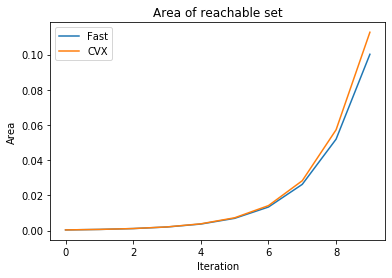

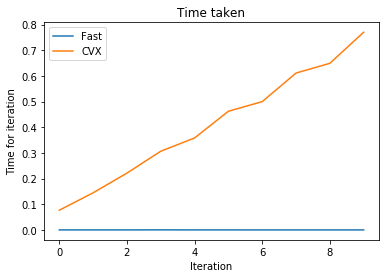

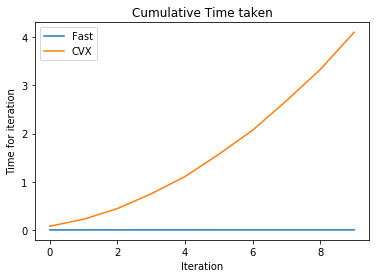

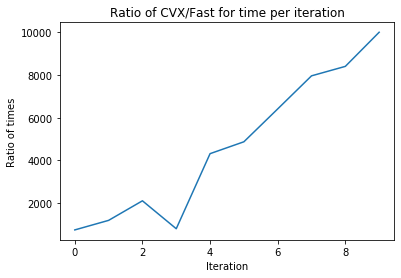

In [17]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

True
True


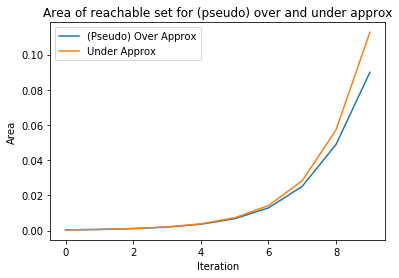

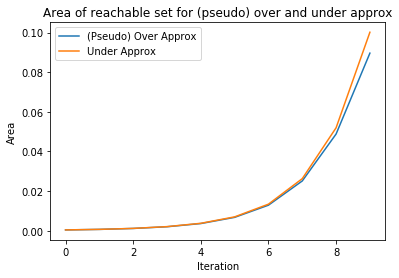

In [18]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerLV,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerLV,constants=constants))

### Clouds

Scatter plot of point clouds for polytope sampling and random sampling (using forward Euler).

Blue is polytope.

Orange is random.

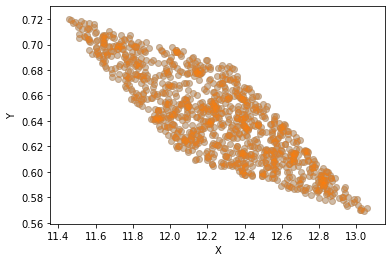

In [58]:
c = constants.copy()
random = get_final_points([x_range,y_range],n=1000,forwardEuler=forwardEulerLV,constants=c,t=-1)
compare_clouds(random, random) # sampled_proj_points
# random

## Testing with Van Der Pol Oscillator

Van Der Pol Oscillator (discretized) dynamics:

$x_{t+1} = -y_t \Delta_t + x_t  $         
$y_{t+1} = -(u_t(1-x_t^2)y_t - x_t) \Delta_t + y_t$

### Forward Euler for Van Der Pol

In [19]:
def forwardEulerVP(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    
    T = constants["T"]
    del_t = constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        u = 1.0
        x, y = x-y*del_t, y - (u*(1-x**2)*y - x)*del_t
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [20]:
# horizon and forward Euler time step
T = 15
del_t = -0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

# Use convex constraints (linear underestimator/overestimator based on convexity properties) where approapriate
use_convex = True

### Fast Reachable Set Computation

$x_{t+1} = -y_t \Delta_t + x_t  $         
$y_{t+1} = -(u_t(1-x_t^2)y_t - x_t) \Delta_t + y_t$

In [21]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
u0_bound = BoxConstraints(0.2,1.0)
var_bounds = {"x":x0_bounds, "y":y0_bounds, "u":u0_bound}

x_0_coeffs = {"x":1, "y":0, "u":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "u":0, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

u_0_coeffs = {"x":0, "y":0, "u":1, "_const":0}
u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    box_x, box_y = x_0.eval_box(), y_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper]))
    
    x_temp = y_0.mult_const(constants["del_t"]*(-1)).add(x_0)
    
    x_squared = None
    if use_convex:
        fn = lambda v: v["x"]**2
        gradient_fn = lambda v: {"x":2*v["x"]}
#         var_map = {"x":x_0}
#         x_squared = ConvexConstraints(var_bounds, fn, gradient_fn, var_map, convex=True, point_grad=None)
        x_squared = ConvexConstraints({"x":x_0},var_bounds, fn, gradient_fn, convex=True)
    else:
        x_squared = x_0.power(2)
    
    y_temp = x_squared.mult_const(-1).add_const(1).mult(u_0).mult(y_0).add(x_0.mult_const(-1)).mult_const(constants["del_t"]*(-1)).add(y_0)
    x_0, y_0 = x_temp, y_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

### CVX Reachable Set Computation

In [22]:
def one_minus_x_squared(w, x, x_bounds):
    a,b = x_bounds # lower, upper bound
    c = []
#     a_times_b = a*b
#     a_plus_b = 
#     print(x)
#     print(l1,l2,l3)
#     print(u1,u2,u3)
    c.append(w >= a*b - (a+b)*x + 1)
    c.append(w <= 1 + ((a+b)**2)/4 - (a+b)*x)
    return c

In [23]:
def VanDerPolConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}):
    times = []
    ss = []
    boxes = []
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        boxes.append(([xL,xU],[yL,yU]))
        ss.append((xU-xL)*(yU-yL))

        u = variables[t]["u"]
        u_bounds = control_bounds[t]
        constraints.append(u <= u_bounds[1])
        constraints.append(u >= u_bounds[0])
        
        if use_convex:
            v = variables[t]["v"]
            constraints.extend(one_minus_x_squared(v,x,x_bounds))
            v_bounds = bounds(v,constraints,Npast=Npast)
        else:
            n = variables[t]["n"]
            constraints.extend(McCormick(n,x,x,x_bounds,x_bounds))

            v = variables[t]["v"]
            constraints.append(v == 1 - n)
            v_bounds = bounds(v,constraints,Npast=Npast)
        

        w = variables[t]["w"]
        constraints.extend(McCormick(w,y,v,y_bounds,v_bounds))
        w_bounds = bounds(w,constraints,Npast=Npast)        

        z = variables[t]["z"]
        constraints.extend(McCormick(z,u,w,u_bounds,w_bounds)) 

        y_new = variables[t+1]["y"]
        constraints.append(y_new == -1*z*del_t + x*del_t + y)

        x_new = variables[t+1]["x"]
        constraints.append(x_new == -y*del_t + x)

        tt = time.time() - tt
        times.append(tt)
    
    return variables,constraints, times, ss,boxes

In [24]:
variables = [{"u":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"z":cvxpy.Variable(),"w":cvxpy.Variable(),"v":cvxpy.Variable(),"n":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

control_bounds = [(0.2,1.0) for t in range(T)]
#control_bounds = [(2.0,2.5),(2.0,2.5),(2.0,2.5),(2.0,2.5)]

variables,constraints,times_convex,areas_convex,boxes_convex = VanDerPolConstraints(T,variables,constraints,control_bounds,use_convex=use_convex,constants=constants)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

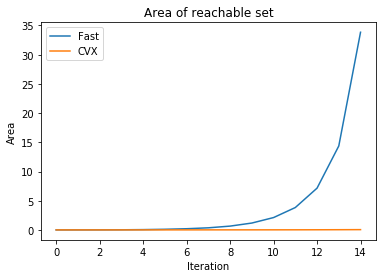

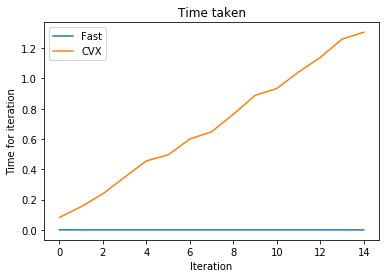

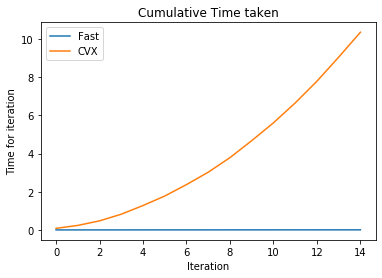

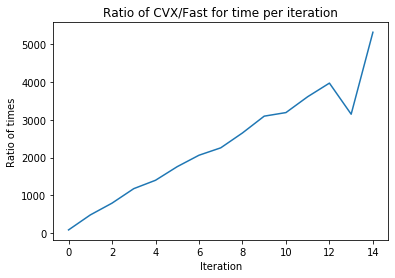

In [25]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

NOTE: Forward euler assumes constant control at $u_t \equiv 1$. Should change in the future.

True
True


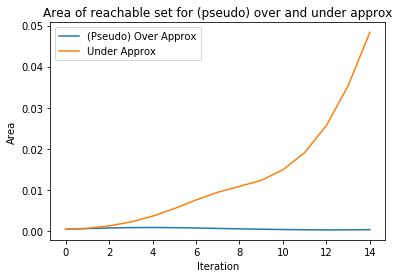

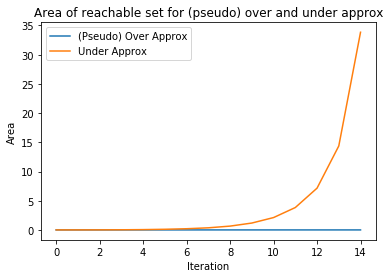

In [26]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerVP,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerVP,constants=constants))

## Testing with Polynomial Nonlinear system

Made-up polynomial (discretized) dynamics:

$x_{t+1} = x_t^3 y_t^2\Delta_t + x_t$         
$y_{t+1} = -x_t y_t\Delta_t + y_t$


### Forward Euler for Polynomial System

In [27]:
def forwardEulerPoly(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    
    T = constants["T"]
    del_t = constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        x, y = (x**3)*(y**2)*del_t + x, -1*x*y*del_t + y
        xs.append(x)
        ys.append(y)
        
#     if plot:
#         plt.figure()
#         plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [28]:
# horizon and forward Euler time step
T = 15
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

### Fast Reachable Set Computation

$x_{t+1} = x_t^3 y_t^2\Delta_t + x_t$         
$y_{t+1} = -x_t y_t\Delta_t + y_t$

In [29]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)

var_bounds = {"x":x0_bounds, "y":y0_bounds}

x_0_coeffs = {"x":1, "y":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    box_x, box_y = x_0.eval_box(), y_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper]))
    
    x_temp = x_0.power(3).mult(y_0.power(2)).mult_const(constants["del_t"]).add(x_0)
    y_temp = x_0.mult(y_0).mult_const(-1*constants["del_t"]).add(y_0)
    x_0, y_0 = x_temp, y_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

### CVX Reachable Set Computation

$x_{t+1} = x_t^3 y_t^2\Delta_t + x_t$         
$y_{t+1} = -x_t y_t\Delta_t + y_t$

In [30]:
def PolyConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}):
    times = []
    ss = []
    boxes = []
    del_t = constants["del_t"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        boxes.append(([xL,xU],[yL,yU]))
        ss.append((xU-xL)*(yU-yL))
        
        # x^2
        x2 = variables[t]["x2"]
        constraints.extend(McCormick(x2,x,x,x_bounds,x_bounds))
        x2_bounds = bounds(x2,constraints,Npast=Npast)
        
        # x^3
        x3 = variables[t]["x3"]
        constraints.extend(McCormick(x3,x2,x,x2_bounds,x_bounds))
        x3_bounds = bounds(x3,constraints,Npast=Npast)
        
        # y^2
        y2 = variables[t]["y2"]
        constraints.extend(McCormick(y2,y,y,y_bounds,y_bounds))
        y2_bounds = bounds(y2,constraints,Npast=Npast)
        
        # x^3 y^2
        x3y2 = variables[t]["x3y2"]
        constraints.extend(McCormick(x3y2,x3,y2,x3_bounds,y2_bounds))
        x3y2_bounds = bounds(x3y2,constraints,Npast=Npast)
        
        # xy
        xy = variables[t]["xy"]
        constraints.extend(McCormick(xy,x,y,x_bounds,y_bounds))
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == x3y2*del_t + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == -1*xy*del_t + y)

        tt = time.time() - tt
        times.append(tt)
    
    return variables,constraints, times, ss,boxes

In [31]:
variables = [{"x":cvxpy.Variable(),"y":cvxpy.Variable(),"x2":cvxpy.Variable(),"x3":cvxpy.Variable(),"y2":cvxpy.Variable(),"x3y2":cvxpy.Variable(),"xy":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

variables,constraints,times_convex,areas_convex,boxes_convex = PolyConstraints(T,variables,constraints,control_bounds,use_convex=False,constants=constants)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

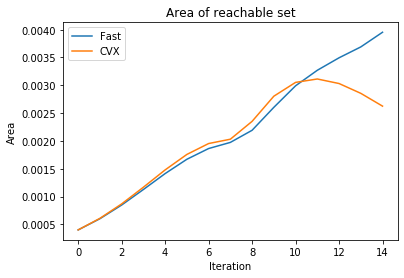

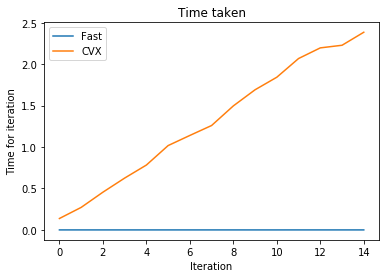

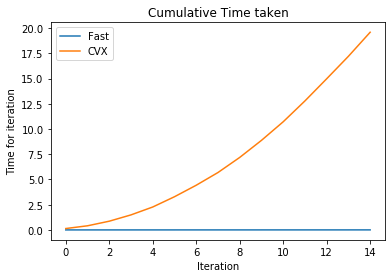

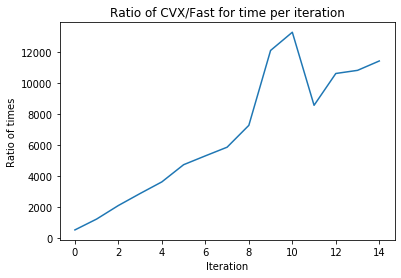

In [32]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

True
True


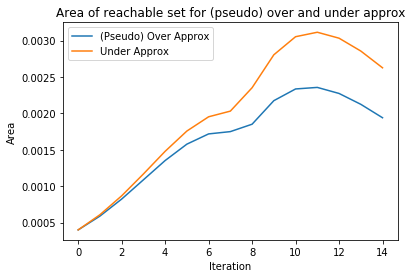

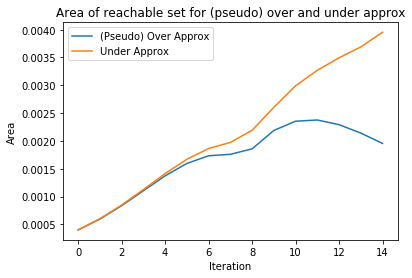

In [33]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerPoly,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerPoly,constants=constants))

## Testing with Dubins' Car

Dubins' car (discretized) dynamics for control input $u_t \in [-1,1]$:

$x_{t+1} = V cos(\theta_t)\Delta_t + x_t$         
$y_{t+1} = V sin(\theta_t)\Delta_t + y_t$     
$\theta_{t+1} = u_t\Delta_t + \theta_t$


### Forward Euler for Dubins' Car

In [34]:
def forwardEulerDC(init,constants,plot=False):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas = [x0], [y0], [theta0]
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(-1,1)
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        
    traj = [(xs[i],ys[i],thetas[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [35]:
# horizon and forward Euler time step
T = 10
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
theta0 = 1
x_dev = 0.01
y_dev = 0.01
theta_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0
theta_up_b = theta_dev + theta0
theta_lw_b = -1*theta_dev + theta0

V = 1

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0, "theta0":theta0, "V":V}

x_range, y_range, theta_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev], [theta0 - theta_dev, theta0 + theta_dev]

### Fast Reachable Set Computation

In [36]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
theta0_bounds = BoxConstraints(theta_lw_b,theta_up_b)
u0_bounds = BoxConstraints(-1,1)

var_bounds = {"x":x0_bounds, "y":y0_bounds, "theta":theta0_bounds, "u":u0_bounds}

x_0_coeffs = {"x":1, "y":0, "theta":0, "u":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "theta":0, "u":0, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

theta_0_coeffs = {"x":0, "y":0, "theta":1, "u":0, "_const":0}
theta_0 = LinearConstraints(Line(theta_0_coeffs.copy()), Line(theta_0_coeffs.copy()),var_bounds)

u_0_coeffs = {"x":0, "y":0, "theta":0, "u":1, "_const":0}
u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    V = constants["V"]
    box_x, box_y, box_theta = x_0.eval_box(), y_0.eval_box(), theta_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper],[box_theta.lower,box_theta.upper]))
    
    x_temp = theta_0.cos(adaptive=True).mult_const(constants["del_t"]*V).add(x_0)
    y_temp = theta_0.sin(adaptive=True).mult_const(constants["del_t"]*V).add(y_0)
    theta_temp = u_0.mult_const(constants["del_t"]).add(theta_0)
    x_0, y_0, theta_0 = x_temp, y_temp, theta_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

### CVX Reachable Set Computation

$x_{t+1} = V cos(\theta)\Delta_t + x_t$         
$y_{t+1} = V sin(\theta)\Delta_t + y_t$     
$\theta_{t+1} = u_t\Delta_t + \theta_t$

In [37]:
def DubinsConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}):
    times = []
    ss = []
    boxes = []
    del_t = constants["del_t"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        theta = variables[t]["theta"]
        theta_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        thetaL,thetaU = theta_bounds
        boxes.append(([xL,xU],[yL,yU],[thetaL,thetaU]))
        ss.append((xU-xL)*(yU-yL)*(thetaU-thetaL))
        
        # del_t*u
        u = variables[t]["u"]
        constraints.append(u <= del_t)
        constraints.append(u >= -1*del_t)
        
        # V*del_t*cosine
        c = variables[t]["c"]
        constraints.append(c <= constants["V"]*del_t)
        constraints.append(c >= -1*constants["V"]*del_t)
        
        # V*del_t*sine
        s = variables[t]["s"]
        constraints.append(s <= constants["V"]*del_t)
        constraints.append(s >= -1*constants["V"]*del_t)
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == c + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == s + y)
        
        theta_new = variables[t+1]["theta"]
        constraints.append(theta_new == u + theta)

        tt = time.time() - tt
        times.append(tt)
    
    return variables,constraints, times, ss, boxes

In [38]:
variables = [{"u":cvxpy.Variable(),"c":cvxpy.Variable(),"s":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"theta":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]
theta = variables[0]["theta"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)
constraints.append(theta >= theta_lw_b)
constraints.append(theta <= theta_up_b)

control_bounds = [(-1,1) for t in range(T)]

variables,constraints,times_convex,areas_convex,boxes_convex = DubinsConstraints(T,variables,constraints,control_bounds,use_convex=False,constants=constants)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)
thetaL,thetaU = bounds(variables[-1]["theta"],constraints)

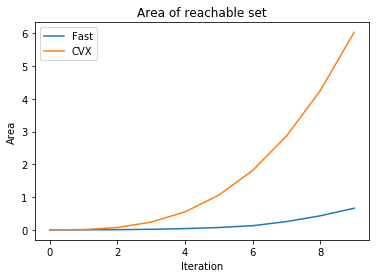

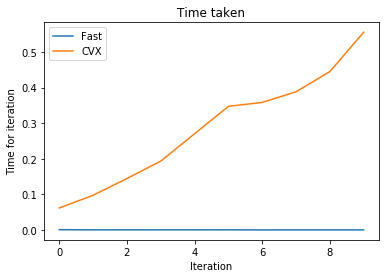

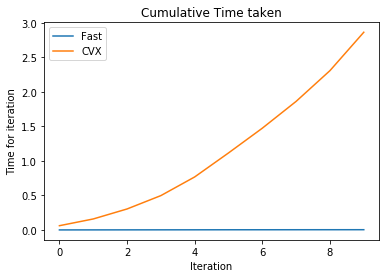

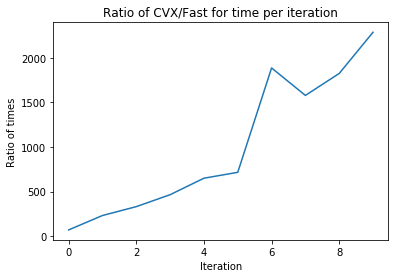

In [39]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

True
True


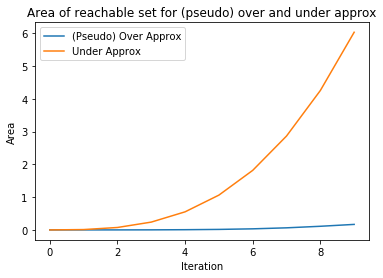

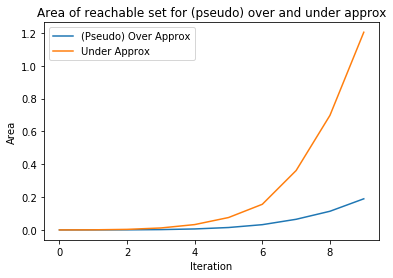

In [40]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range,theta_range],n=num_samples,forwardEuler=forwardEulerDC,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range,theta_range],n=num_samples,forwardEuler=forwardEulerDC,constants=constants))